In [0]:
import numpy as np
from scipy import misc
from imp import reload

import random
from __future__ import absolute_import, division, print_function
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ColorConverter
import random as rnd
from sklearn.datasets.samples_generator import make_blobs
from sklearn import decomposition, tree
import seaborn as sns
sns.set()

In [0]:


def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ellip.set_alpha(0.25)

    ax.add_artist(ellip)
    return ellip


In [0]:
# Splits data into training and test set, pcSplit defines the percent of
# the data should be used as training data.
def trteSplit(X,y,pcSplit,seed=None):
    # Compute split indices
    Ndata = X.shape[0]
    Ntr = int(np.rint(Ndata*pcSplit))
    Nte = Ndata-Ntr
    np.random.seed(seed)    
    idx = np.random.permutation(Ndata)
    trIdx = idx[:Ntr]
    teIdx = idx[Ntr:]
    # Split data
    xTr = X[trIdx,:]
    yTr = y[trIdx]
    xTe = X[teIdx,:]
    yTe = y[teIdx]
    return xTr,yTr,xTe,yTe,trIdx,teIdx


In [0]:
# Splits data into training and test set, pcSplit defines the percent of
# the data should be used as training data. The major difference to
# trteSplit is that we select the percent from each class individually.
# This means that we are assured to have enough points for each class.
def trteSplitEven(X,y,pcSplit,seed=None):
    labels = np.unique(y)
    xTr = np.zeros((0,X.shape[1]))
    xTe = np.zeros((0,X.shape[1]))
    yTe = np.zeros((0,),dtype=int)
    yTr = np.zeros((0,),dtype=int)
    trIdx = np.zeros((0,),dtype=int)
    teIdx = np.zeros((0,),dtype=int)
    np.random.seed(seed)
    for label in labels:
        classIdx = np.where(y==label)[0]
        NPerClass = len(classIdx)
        Ntr = int(np.rint(NPerClass*pcSplit))
        idx = np.random.permutation(NPerClass)
        trClIdx = classIdx[idx[:Ntr]]
        teClIdx = classIdx[idx[Ntr:]]
        trIdx = np.hstack((trIdx,trClIdx))
        teIdx = np.hstack((teIdx,teClIdx))
        # Split data
        xTr = np.vstack((xTr,X[trClIdx,:]))
        yTr = np.hstack((yTr,y[trClIdx]))
        xTe = np.vstack((xTe,X[teClIdx,:]))
        yTe = np.hstack((yTe,y[teClIdx]))

    return xTr,yTr,xTe,yTe,trIdx,teIdx

In [0]:
def fetchDataset(dataset='iris'):
    if dataset == 'iris':
        X = genfromtxt('irisX.txt', delimiter=',')
        y = genfromtxt('irisY.txt', delimiter=',',dtype=np.int)-1
        pcadim = 2
    elif dataset == 'wine':
        X = genfromtxt('wineX.txt', delimiter=',')
        y = genfromtxt('wineY.txt', delimiter=',',dtype=np.int)-1
        pcadim = 0
    elif dataset == 'olivetti':
        X = genfromtxt('olivettifacesX.txt', delimiter=',')
        X = X/255
        y = genfromtxt('olivettifacesY.txt', delimiter=',',dtype=np.int)
        pcadim = 20
    elif dataset == 'vowel':
        X = genfromtxt('vowelX.txt', delimiter=',')
        y = genfromtxt('vowelY.txt', delimiter=',',dtype=np.int)
        pcadim = 0
    else:
        print("Please specify a dataset!")
        X = np.zeros(0)
        y = np.zeros(0)
        pcadim = 0

    return X,y,pcadim


In [0]:
def genBlobs(n_samples=200,centers=5,n_features=2):
    X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features,random_state=0)
    return X,y


In [0]:
# Scatter plots the two first dimension of the given data matrix X
# and colors the points by the labels.
def scatter2D(X,y):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=25,color=colors[label],marker='o',alpha=0.75)
        c += 1.

    plt.show()


In [0]:
def plotGaussian(X,y,mu,sigma):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = y==label
        Xclass = X[classIdx,:]
        plot_cov_ellipse(sigma[label], mu[label])
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=25,color=colors[label],marker='o',alpha=0.75)
        c += 1.

    plt.show()

In [0]:
# The function below, `testClassifier`, will be used to try out the different datasets.
# `fetchDataset` can be provided with any of the dataset arguments `wine`, `iris`, `olivetti` and `vowel`.
# Observe that we split the data into a **training** and a **testing** set.
def testClassifier(classifier, dataset='iris', dim=0, split=0.7, ntrials=100):

    X,y,pcadim = fetchDataset(dataset)

    means = np.zeros(ntrials,);

    for trial in range(ntrials):

        xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split,trial)

        # Do PCA replace default value if user provides it
        if dim > 0:
            pcadim = dim

        if pcadim > 0:
            pca = decomposition.PCA(n_components=pcadim)
            pca.fit(xTr)
            xTr = pca.transform(xTr)
            xTe = pca.transform(xTe)

        # Train
        trained_classifier = classifier.trainClassifier(xTr, yTr)
        # Predict
        yPr = trained_classifier.classify(xTe)

        # Compute classification error
        if trial % 10 == 0:
            print("Trial:",trial,"Accuracy","%.3g" % (100*np.mean((yPr==yTe).astype(float))) )

        means[trial] = 100*np.mean((yPr==yTe).astype(float))

    print("Final mean classification accuracy ", "%.3g" % (np.mean(means)), "with standard deviation", "%.3g" % (np.std(means)))



In [0]:
# ## Plotting the decision boundary
#
# This is some code that you can use for plotting the decision boundary
# boundary in the last part of the lab.
def plotBoundary(classifier, dataset='iris', split=0.7):

    X,y,pcadim = fetchDataset(dataset)
    xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split,1)
    classes = np.unique(y)

    pca = decomposition.PCA(n_components=2)
    pca.fit(xTr)

    xTr = pca.transform(xTr)
    xTe = pca.transform(xTe)

    pX = np.vstack((xTr, xTe))
    py = np.hstack((yTr, yTe))

    # Train
    trained_classifier = classifier.trainClassifier(xTr, yTr)

    xRange = np.arange(np.min(pX[:,0]),np.max(pX[:,0]),np.abs(np.max(pX[:,0])-np.min(pX[:,0]))/100.0)
    yRange = np.arange(np.min(pX[:,1]),np.max(pX[:,1]),np.abs(np.max(pX[:,1])-np.min(pX[:,1]))/100.0)

    grid = np.zeros((yRange.size, xRange.size))

    for (xi, xx) in enumerate(xRange):
        for (yi, yy) in enumerate(yRange):
            # Predict
            grid[yi,xi] = trained_classifier.classify(np.array([[xx, yy]]))

    
    ys = [i+xx+(i*xx)**2 for i in range(len(classes))]
    colormap = cm.rainbow(np.linspace(0, 1, len(ys)))

    fig = plt.figure()
    # plt.hold(True)
    conv = ColorConverter()
    for (color, c) in zip(colormap, classes):
        try:
            CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
        except ValueError:
            pass
        trClIdx = np.where(y[trIdx] == c)[0]
        teClIdx = np.where(y[teIdx] == c)[0]
        plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
        plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")
    plt.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    fig.subplots_adjust(right=0.7)
    plt.show()

In [0]:
def visualizeOlivettiVectors(xTr, Xte):
    N = xTr.shape[0]
    Xte = Xte.reshape(64, 64).transpose()
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Test image")
    plt.imshow(Xte, cmap=plt.get_cmap('gray'))
    for i in range(0, N):
        plt.subplot(N, 2, 2+2*i)
        plt.xticks([])
        plt.yticks([])
        plt.title("Matched class training image %i" % (i+1))
        X = xTr[i, :].reshape(64, 64).transpose()
        plt.imshow(X, cmap=plt.get_cmap('gray'))
    plt.show()


In [0]:
class DecisionTreeClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, Xtr, yTr, W=None):
        rtn = DecisionTreeClassifier()
        rtn.classifier = tree.DecisionTreeClassifier(max_depth=Xtr.shape[1]/2+1)
        if W is None:
            rtn.classifier.fit(Xtr, yTr)
        else:
            rtn.classifier.fit(Xtr, yTr, sample_weight=W.flatten())
        rtn.trained = True
        return rtn

    def classify(self, X):
        return self.classifier.predict(X)

## Bayes classifier functions to implement


In [0]:
# ## Bayes classifier functions to implement
# 
# The lab descriptions state what each function should do.


# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    for i in range(Nclasses):
      Npts_classi = labels[np.where(labels==classes[i])].shape[0]
      prior[i] = Npts_classi / Npts
      

    # ==========================
    return prior

In [0]:
# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    
    for k in range(Nclasses):
      X_classe_k = X[np.where(labels==classes[k])]
      W_classe_k = W[np.where(labels==classes[k])]
      
      
      mu[k] = np.average(X_classe_k,weights = W_classe_k, axis = 0 )
      sigma_k_vector = np.average(np.power((X_classe_k - mu[k]), 2),weights =W_classe_k, axis=0)
      
      sigma[k]=np.diag(sigma_k_vector)

      #sigma[k] = np.cov(X_classe_k.T ) better performance but not diagonal 
    # ==========================

    return mu, sigma


In [0]:
    from scipy.stats import multivariate_normal

In [0]:
# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
#def classifyBayes(X, prior, mu, sigma):

#    Npts = X.shape[0]
#    Nclasses,Ndims = np.shape(mu)
#    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    #term_1 = -np.sum(np.log(np.sqrt(2*np.pi*sigma)))
    #term_2 = - np.sum((X-mu)/(2*sigma))

#    for i in range(Nclasses):
#      log_Likelihood = multivariate_normal.logpdf(X, mean=mu[i], cov=sigma[i])
#      logProb[i,:] = np.sum([log_Likelihood,np.log(prior[i])])
    
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
#    h = np.argmax(logProb,axis=0)
#    return h

In [0]:
#pQS LQ NOTRE

def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    for i in range(0, Nclasses):
        p1=-0.5*np.log(np.linalg.det(sigma[i]))
        inve = np.diag(1.0 / np.diag(sigma[i]))
        #p2 = -0.5 * np.diag(np.dot(np.dot((X - mu[i]), inve),np.transpose(X - mu[i])))
        p2=-0.5*np.diag(np.dot(np.dot((X-mu[i]), inve),np.transpose(X-mu[i])))
        p3=np.log(prior[i])
        logProb[i,:] =p1+p2+p3
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h


In [0]:
# The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:


# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)



In [0]:
### import datasets 

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

Saving irisX.txt to irisX (2).txt
Saving irisY.txt to irisY (2).txt
Saving olivettifacesX.txt to olivettifacesX (2).txt
Saving olivettifacesY.txt to olivettifacesY (1).txt
Saving wineX.txt to wineX (1).txt
Saving wineY.txt to wineY (1).txt
Saving vowelX.txt to vowelX (1).txt
Saving vowelY.txt to vowelY (1).txt
User uploaded file "irisY.txt" with length 299 bytes
User uploaded file "irisX.txt" with length 9184 bytes
User uploaded file "olivettifacesY.txt" with length 1099 bytes
User uploaded file "olivettifacesX.txt" with length 6192775 bytes
User uploaded file "wineY.txt" with length 355 bytes
User uploaded file "wineX.txt" with length 33248 bytes
User uploaded file "vowelY.txt" with length 1103 bytes
User uploaded file "vowelX.txt" with length 33650 bytes


In [0]:
irisX = np.genfromtxt('irisX.txt', delimiter=',')
irisY = np.genfromtxt('irisY.txt', delimiter=',')

olivettifacesX = np.genfromtxt('olivettifacesX.txt', delimiter=',')
olivettifacesY = np.genfromtxt('olivettifacesY.txt', delimiter=',')

wineX = np.genfromtxt('wineX.txt', delimiter=',')
wineY = np.genfromtxt('wineY.txt', delimiter=',')


vowelX = np.genfromtxt('vowelX.txt', delimiter=',')
vowelY = np.genfromtxt('vowelY.txt', delimiter=',')

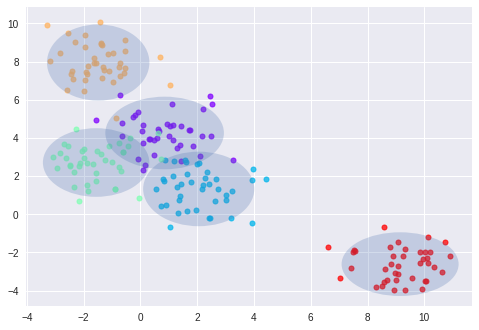

dataset = iris
Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16
dataset = vowel
Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03
boundary = iris


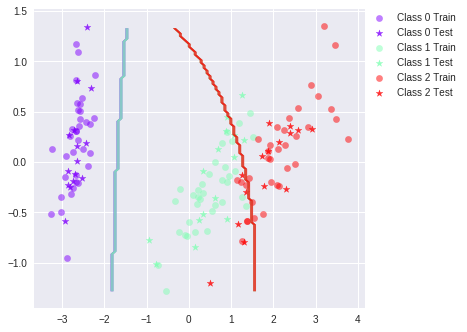

In [0]:

# ## Test the Maximum Likelihood estimates
# 
# Call `genBlobs` and `plotGaussian` to verify your estimates.


X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)


# Call the `testClassifier` and `plotBoundary` functions for this part.

print('dataset = iris')
testClassifier(BayesClassifier(), dataset='iris', split=0.7)


print('dataset = vowel')
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)


print('boundary = iris')
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)


# ## Boosting functions to implement
 The lab descriptions state what each function should do.
THe problem is in trainBoost

In [0]:
# ## Boosting functions to implement
# 
# The lab descriptions state what each function should do.


# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))
      # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        miss_classified = 1-(1*(vote == labels))
        error = np.inner(wCur, miss_classified)
        alpha = 0.5*(np.log(1-error) - np.log(error))
        alphas.append(alpha)

        wCur_not_normalized = wCur*( np.exp(-alpha)*(vote == labels) + np.exp(alpha) * miss_classified)
        wCur = wCur_not_normalized / (wCur_not_normalized.sum())
          # alphas.append(alpha) # you will need to append the new alpha
          # ==========================
          #there were an indentation
    return classifiers, alphas

        

In [0]:
# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)
    
    
    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
      return classifiers[0].classify(X)
      
    else:
      votes = np.zeros((Npts,Nclasses))
      
        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
      a = np.array([alphas[i] *(classifiers[i].classify(X)) for i in range(Ncomps)])
      votes = np.sum(a, axis=1)
    
        # one way to compute yPred after accumulating the votes
      yPred = np.argmax(votes)
    return yPred



In [0]:

# The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.


# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)



## Run some experiments  BAAD RESULTS

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

test = AdaBoostClassifier(GaussianNB(), n_estimators=10)



xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplit(irisX,irisY,0.7,seed=None)

test.fit(xTr,yTr)
X = test.predict(xTe)
print(X)
print(yTe)
#test.score(X, yTe)


[2. 1. 1. 1. 3. 1. 1. 1. 3. 1. 2. 2. 3. 3. 3. 2. 3. 3. 1. 1. 2. 3. 2. 3.
 3. 1. 3. 2. 2. 1. 3. 3. 2. 2. 1. 1. 1. 3. 3. 1. 1. 3. 1. 3. 3.]
[2. 1. 1. 1. 2. 1. 1. 1. 3. 1. 2. 2. 3. 3. 3. 2. 3. 3. 1. 1. 2. 3. 2. 3.
 3. 1. 3. 2. 2. 1. 3. 3. 2. 2. 1. 1. 1. 2. 3. 1. 1. 3. 1. 3. 3.]


Trial: 0 Accuracy 33.3
Trial: 10 Accuracy 33.3
Trial: 20 Accuracy 33.3


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Trial: 30 Accuracy 33.3
Trial: 40 Accuracy 33.3
Trial: 50 Accuracy 33.3
Trial: 60 Accuracy 33.3
Trial: 70 Accuracy 33.3
Trial: 80 Accuracy 33.3
Trial: 90 Accuracy 33.3
Final mean classification accuracy  33.3 with standard deviation 0
Trial: 0 Accuracy 9.09
Trial: 10 Accuracy 9.09
Trial: 20 Accuracy 9.09
Trial: 30 Accuracy 9.09
Trial: 40 Accuracy 9.09
Trial: 50 Accuracy 9.09
Trial: 60 Accuracy 9.09
Trial: 70 Accuracy 9.09
Trial: 80 Accuracy 9.09
Trial: 90 Accuracy 9.09
Final mean classification accuracy  9.09 with standard deviation 1.78e-15


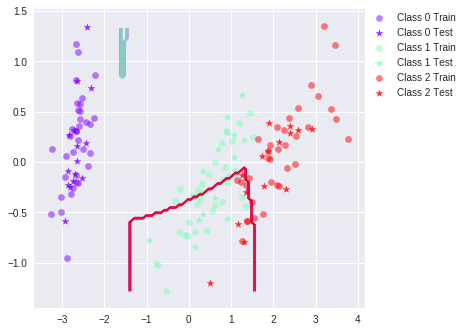

In [0]:

# ## Run some experiments
# 
# Call the `testClassifier` and `plotBoundary` functions for this part.


testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)



testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)



plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

# Now repeat the steps with a decision tree classifier.

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71
Trial: 0 Accuracy 33.3
Trial: 10 Accuracy 33.3
Trial: 20 Accuracy 33.3
Trial: 30 Accuracy 33.3
Trial: 40 Accuracy 33.3
Trial: 50 Accuracy 33.3
Trial: 60 Accuracy 33.3
Trial: 70 Accuracy 33.3
Trial: 80 Accuracy 0
Trial: 90 Accuracy 33.3
Final mean classification accuracy  28.7 with standard deviation 11.6
Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4
Trial: 0 Accuracy 9.09
Trial: 10 Accuracy 9.09
Trial: 20 Accuracy 9.09
Trial: 30 A

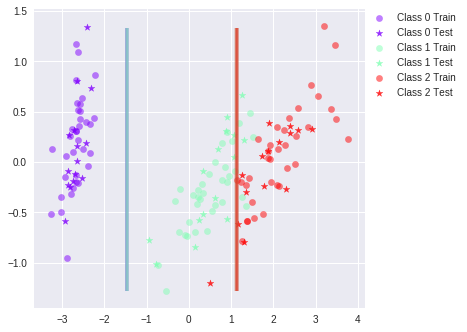

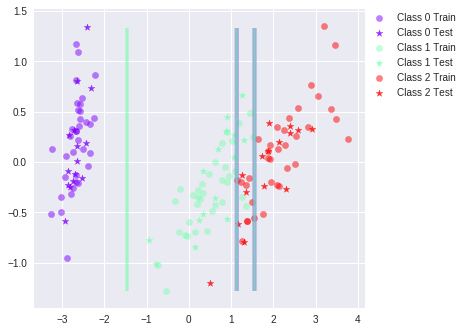

In [0]:
# Now repeat the steps with a decision tree classifier.


testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)



testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)



testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)



testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)



plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)



plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)



## Bonus: Visualize faces classified using boosted decision trees

In [0]:

 ## Bonus: Visualize faces classified using boosted decision trees
# 
# Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.


testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)



testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)


# You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!


X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])


Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03
Trial: 0 Accuracy 2.5
Trial: 10 Accuracy 2.5
Trial: 20 Accuracy 2.5
Trial: 30 Accuracy 2.5
Trial: 40 Accuracy 2.5
Trial: 50 Accuracy 2.5
Trial: 60 Accuracy 2.5
Trial: 70 Accuracy 2.5
Trial: 80 Accuracy 2.5
Trial: 90 Accuracy 2.5
Final mean classification accuracy  2.5 with standard deviation 0


IndexError: ignored